In [83]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier             # for correalation evaluatoin of catagorial data
from sklearn.preprocessing import LabelEncoder                # for encoding categorial data
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
#from scipy.stats import spearmanr, chi2    

from fancyimpute import KNN

from xgboost import XGBClassifier

from itertools import combinations

import csv

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (5, 5)

In [84]:
loan = pd.read_csv("loan.csv")
applicant = pd.read_csv("applicant.csv")
df = pd.merge(left=loan,right=applicant, how="inner",on="applicant_id")
df.head()

,loan_application_id,applicant_id,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,...,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Telephone,Foreign_worker,Savings_account_balance,Balance_in_existing_bank_account_(lower_limit_of_bucket),Balance_in_existing_bank_account_(upper_limit_of_bucket)
0,d68d975e-edad-11ea-8761-1d6f9c1ff461,1469590,6,electronic equipment,1169000,4,real estate,0,0,NaN,...,own,4,skilled employee / official,7 years,NaN,Registered under the applicant's name,1,NaN,NaN,0
1,d68d989e-edad-11ea-b1d5-2bcf65006448,1203873,48,electronic equipment,5951000,2,real estate,0,0,NaN,...,own,2,skilled employee / official,1 year,4 years,NaN,1,Low,0,2 lac
2,d68d995c-edad-11ea-814a-1b6716782575,1432761,12,education,2096000,2,real estate,0,0,NaN,...,own,3,unskilled - resident,4 years,7 years,NaN,1,Low,NaN,NaN
3,d68d99fc-edad-11ea-8841-17e8848060ae,1207582,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,...,for free,4,skilled employee / official,4 years,7 years,NaN,1,Low,NaN,0
4,d68d9a92-edad-11ea-9f3d-1f8682db006a,1674436,24,new vehicle,4870000,3,NaN,0,0,NaN,...,for free,4,skilled employee / official,1 year,4 years,NaN,1,Low,NaN,0


In [85]:
df = df.drop(['applicant_id', 'Has_been_employed_for_at_most', 'Other_EMI_plans', 'loan_application_id', 'Telephone', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)', 'Balance_in_existing_bank_account_(lower_limit_of_bucket)'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Months_loan_taken_for                        1000 non-null   int64 
 1   Purpose                                      988 non-null    object
 2   Principal_loan_amount                        1000 non-null   int64 
 3   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64 
 4   Property                                     846 non-null    object
 5   Has_coapplicant                              1000 non-null   int64 
 6   Has_guarantor                                1000 non-null   int64 
 7   Number_of_existing_loans_at_this_bank        1000 non-null   int64 
 8   Loan_history                                 1000 non-null   object
 9   high_risk_applicant                          1000 non-null   int64 
 10  Primary_appli

In [86]:
le = LabelEncoder()
encoder = OrdinalEncoder()      # define ordinal encoding

#X = pd.get_dummies(X, columns=['Purpose','Loan_history'], prefix=['Purpose','Loan_history'])   #OneHotFeature Encoding

df['Property'] = le.fit_transform(df['Property'])
df['Gender'] = le.fit_transform(df['Gender'])
df['Marital_status'] = le.fit_transform(df['Marital_status'])
df['Housing'] = le.fit_transform(df['Housing'])
df['Employment_status'] = le.fit_transform(df['Employment_status'])

df['Purpose'] = df.Purpose.map({'education':0, 'new vehicle':1, 'repair costs':2, 'business':3, 'domestic appliances':4, 'FF&E':5,  'electronic equipment':6, 'used vehicle':7, 'career development':8})
df['Loan_history'] = df.Loan_history.map({'existing loans paid back duly till now':3, 'critical/pending loans at other banks':4, 'delay in paying off loans in the past':2, 'all loans at this bank paid back duly':1, 'no loans taken/all loans paid back duly':0})
df['Savings_account_balance'] = df.Savings_account_balance.map({'Low':0, 'Medium':1, 'High':2, 'Very high':3})

df['Loan_history'] = encoder.fit_transform(df['Loan_history'].to_numpy().reshape(-1, 1))
df['Purpose'] = encoder.fit_transform(df['Purpose'].to_numpy().reshape(-1, 1))
df['EMI_rate_in_percentage_of_disposable_income'] = encoder.fit_transform(df['EMI_rate_in_percentage_of_disposable_income'].to_numpy().reshape(-1, 1))
df['Savings_account_balance'] = encoder.fit_transform(df['Savings_account_balance'].to_numpy().reshape(-1, 1))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Months_loan_taken_for                        1000 non-null   int64  
 1   Purpose                                      988 non-null    float64
 2   Principal_loan_amount                        1000 non-null   int64  
 3   EMI_rate_in_percentage_of_disposable_income  1000 non-null   float64
 4   Property                                     1000 non-null   int32  
 5   Has_coapplicant                              1000 non-null   int64  
 6   Has_guarantor                                1000 non-null   int64  
 7   Number_of_existing_loans_at_this_bank        1000 non-null   int64  
 8   Loan_history                                 1000 non-null   float64
 9   high_risk_applicant                          1000 non-null   int64  
 10  P

,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Foreign_worker,Savings_account_balance
0,6,6.0,1169000,3.0,2,0,0,2,4.0,0,67,1,3,1,1,4,1,7 years,1,NaN
1,48,6.0,5951000,1.0,2,0,0,1,3.0,1,22,0,1,1,1,2,1,1 year,1,0.0
2,12,0.0,2096000,1.0,2,0,0,1,4.0,0,49,1,3,2,1,3,3,4 years,1,0.0
3,42,5.0,7882000,1.0,0,0,1,1,3.0,0,45,1,3,2,0,4,1,4 years,1,0.0
4,24,1.0,4870000,2.0,3,0,0,2,2.0,1,53,1,3,2,0,4,1,1 year,1,0.0


In [87]:
def str_split(input_column):
    temp = input_column.str.split(' ', expand=True)
    temp = temp.iloc[:,0]

    count = pd.Series(temp).value_counts()
    #print(count)
    
    input_column = temp

    return input_column
#df.Has_been_employed_for_at_most = str_split(df.Has_been_employed_for_at_most)
df.Has_been_employed_for_at_least = str_split(df.Has_been_employed_for_at_least)
df.head()

,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Foreign_worker,Savings_account_balance
0,6,6.0,1169000,3.0,2,0,0,2,4.0,0,67,1,3,1,1,4,1,7,1,NaN
1,48,6.0,5951000,1.0,2,0,0,1,3.0,1,22,0,1,1,1,2,1,1,1,0.0
2,12,0.0,2096000,1.0,2,0,0,1,4.0,0,49,1,3,2,1,3,3,4,1,0.0
3,42,5.0,7882000,1.0,0,0,1,1,3.0,0,45,1,3,2,0,4,1,4,1,0.0
4,24,1.0,4870000,2.0,3,0,0,2,2.0,1,53,1,3,2,0,4,1,1,1,0.0


In [88]:
#df.dropna(subset=['Purpose'], inplace=True)      # removing the 12 rows / entries which had missing data in Purpose column

df['Principal_loan_amount'] = df['Principal_loan_amount']/1000
df['Months_loan_taken_for'] = df['Months_loan_taken_for']/12

'''
#print(len(np.unique(df.Savings_account_balance)))
#print(np.unique(df.Savings_account_balance))
count = pd.Series(df.Savings_account_balance).value_counts()
print(count)
'''

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Months_loan_taken_for                        1000 non-null   float64
 1   Purpose                                      988 non-null    float64
 2   Principal_loan_amount                        1000 non-null   float64
 3   EMI_rate_in_percentage_of_disposable_income  1000 non-null   float64
 4   Property                                     1000 non-null   int32  
 5   Has_coapplicant                              1000 non-null   int64  
 6   Has_guarantor                                1000 non-null   int64  
 7   Number_of_existing_loans_at_this_bank        1000 non-null   int64  
 8   Loan_history                                 1000 non-null   float64
 9   high_risk_applicant                          1000 non-null   int64  
 10  P

In [89]:
temp = 'Loan_history'
df[[temp, 'high_risk_applicant']].groupby([temp], as_index=False).mean().sort_values(by=temp, ascending=False)

,Loan_history,high_risk_applicant
4,4.0,0.170648
3,3.0,0.318868
2,2.0,0.318182
1,1.0,0.571429
0,0.0,0.625000


In [90]:

def correlation(input_df, output_df):
    #pearson_correlation_coef_matrix = input_df.corr()       # Evaluating Correlation btw Continuous valued Features (with each other & Target Var)
    # i=i*-1 for i in pearson_correlation_coef_matrix: if i<0:
    # pearson_correlation_coef_matrix.high_risk_applicant.plot(kind='barh')
    
    select = SelectKBest(k=15)
    select.fit_transform(input_df, output_df)
    f_imp = pd.Series(select.scores_, index=input_df.columns)
    f_imp.nlargest(14).plot(kind='barh')
    plt.show()
    f_imp.nlargest(15)
    '''
    dfscores = pd.DataFrame(fit.scores_.reshape(-1,1))
    dfcolumns = pd.DataFrame(X_index)
    x_new = fit.transform(input_df)
    featuresScores = pd.concat([dfscores, dfcolumns], axis = 1)
    featuresScores.columns = ['Feature', 'Score']
    '''
    return f_imp.nlargest(15)

def feture_importance_categorical(input_var, output_var, index_column):
    model = ExtraTreesClassifier()
    model.fit(input_var,output_var)
    print(model.feature_importances_)
    f_imp = pd.Series(model.feature_importances_, index=index_column)
    f_imp.nlargest(15).plot(kind='barh')
    plt.show()
    return 0

In [91]:
y = df['high_risk_applicant']                    # Target Variable Initialization
X = df.drop(['high_risk_applicant'], axis=1)     # Training Variable Initialization

def fill_missing_values(df_name):
    imputer = KNNImputer(n_neighbors=5)
    df_name = imputer.fit_transform(df_name)
    return df_name

X_columns = X.columns

X.isnull().sum()
X.head()

,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,Loan_history,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Foreign_worker,Savings_account_balance
0,0.5,6.0,1169.0,3.0,2,0,0,2,4.0,67,1,3,1,1,4,1,7,1,NaN
1,4.0,6.0,5951.0,1.0,2,0,0,1,3.0,22,0,1,1,1,2,1,1,1,0.0
2,1.0,0.0,2096.0,1.0,2,0,0,1,4.0,49,1,3,2,1,3,3,4,1,0.0
3,3.5,5.0,7882.0,1.0,0,0,1,1,3.0,45,1,3,2,0,4,1,4,1,0.0
4,2.0,1.0,4870.0,2.0,3,0,0,2,2.0,53,1,3,2,0,4,1,1,1,0.0


In [92]:
imputer = KNN()

X = pd.DataFrame(np.round(imputer.fit_transform(X)),columns = X_columns)

print(X.info())

X.head()

Imputing row 1/1000 with 1 missing, elapsed time: 0.230
Imputing row 101/1000 with 0 missing, elapsed time: 0.232
Imputing row 201/1000 with 0 missing, elapsed time: 0.234
Imputing row 301/1000 with 1 missing, elapsed time: 0.235
Imputing row 401/1000 with 0 missing, elapsed time: 0.236
Imputing row 501/1000 with 0 missing, elapsed time: 0.237
Imputing row 601/1000 with 0 missing, elapsed time: 0.238
Imputing row 701/1000 with 0 missing, elapsed time: 0.240
Imputing row 801/1000 with 0 missing, elapsed time: 0.242
Imputing row 901/1000 with 0 missing, elapsed time: 0.243
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Months_loan_taken_for                        1000 non-null   float64
 1   Purpose                                      1000 non-null   float64
 2   Principal_loan_

,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,Loan_history,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Foreign_worker,Savings_account_balance
0,0.0,6.0,1169.0,3.0,2.0,0.0,0.0,2.0,4.0,67.0,1.0,3.0,1.0,1.0,4.0,1.0,7.0,1.0,0.0
1,4.0,6.0,5951.0,1.0,2.0,0.0,0.0,1.0,3.0,22.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
2,1.0,0.0,2096.0,1.0,2.0,0.0,0.0,1.0,4.0,49.0,1.0,3.0,2.0,1.0,3.0,3.0,4.0,1.0,0.0
3,4.0,5.0,7882.0,1.0,0.0,0.0,1.0,1.0,3.0,45.0,1.0,3.0,2.0,0.0,4.0,1.0,4.0,1.0,0.0
4,2.0,1.0,4870.0,2.0,3.0,0.0,0.0,2.0,2.0,53.0,1.0,3.0,2.0,0.0,4.0,1.0,1.0,1.0,0.0


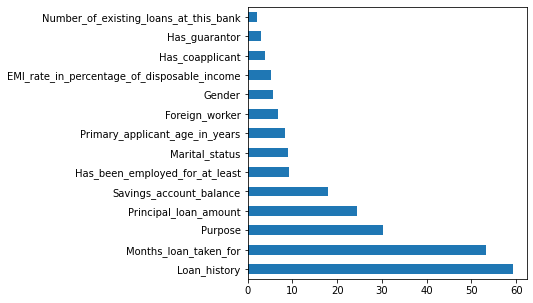

[0.08327613 0.08231527 0.10236642 0.05998158 0.06581524 0.01485026
 0.01315474 0.04121678 0.08243971 0.0939344  0.02487599 0.04026107
 0.02716843 0.03916417 0.05829161 0.05075522 0.06879314 0.00866469
 0.04267516]


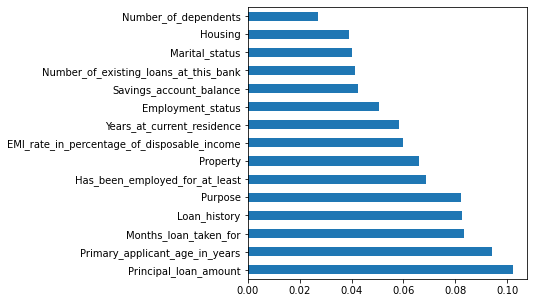

0

In [93]:
correlation(X,y)

feture_importance_categorical(X, y, X_columns)

In [94]:
scaler = StandardScaler()

X = X[['Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Property',
       'Primary_applicant_age_in_years', 'Gender', 'Marital_status',
       'Number_of_dependents', 'Years_at_current_residence']]

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1)      # splitting for training data

#X_cv, X_test, y_cv, y_test = train_test_split(X_test,y_test,test_size=0.5, random_state=1)  # splitting for Dev and Test sets

In [95]:
X.shape

(1000, 9)

In [ ]:
# Neural Networks Implementation

#analysis = []
'''
for i in [2, 4, 8, 16, 32, 64, 128]:
    for j in [0, 2, 4, 8, 16, 32]:
        
        model_NN = Sequential([Dense(units = i, activation='relu', name = 'layer_1', input_dim = 20, kernel_regularizer=tf.keras.regularizers.l1_l2(
            l1=0.0, l2=0.00)),
                               Dense(units = j, activation='relu', name = 'layer_2', kernel_regularizer=tf.keras.regularizers.l1_l2(
            l1=0.0, l2=0.00)),
                               Dense(units = 1, activation='sigmoid', name = 'layer_3'),
                              ])

        model_NN.compile(loss=BinaryCrossentropy(), 
                         optimizer = Adam(learning_rate = 0.01),
                        metrics=tf.keras.metrics.BinaryAccuracy())

        model_NN.fit(X_norm_train,y_train, epochs=100, verbose=0)

        score = model_NN.evaluate(X_norm_cv, y_cv, verbose=1)
        
        analysis.append([i,j,score])

'''        
'''
        y_predict_NN = model_NN.predict(X_norm_test)
        y_predict_NN[y_predict_NN >= 0.5] = 1
        y_predict_NN[y_predict_NN < 0.5] = 0

        acc_NN = sklearn.metrics.accuracy_score(y_predict_NN,y_test)
'''

#print(analysis)

In [102]:
# Neural Networks Implementation

model_NN = Sequential([Dense(units = 32, activation='relu', name = 'layer_1', input_dim = 9, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.009)),
                       Dense(units = 64, activation='relu', name = 'layer_2', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.009)),
                       Dense(units = 16, activation='relu', name = 'layer_3', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0, l2=0.009)),
                       Dense(units = 1, activation='sigmoid', name = 'layer_4'),
                      ])

model_NN.compile(loss=BinaryCrossentropy(),
                 optimizer = Adam(learning_rate = 0.000075),
                metrics=tf.keras.metrics.BinaryAccuracy())

model_NN.fit(X_train,y_train, epochs=1000)

score = model_NN.evaluate(X_test, y_test, verbose=1)

Epoch 1/1000
27/27 [==============================] - 1s 2ms/step - loss: 1.4494 - binary_accuracy: 0.3741
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.4245 - binary_accuracy: 0.4176
Epoch 3/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.4018 - binary_accuracy: 0.5247
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3813 - binary_accuracy: 0.5953
Epoch 5/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.3617 - binary_accuracy: 0.6435
Epoch 6/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.3435 - binary_accuracy: 0.6753
Epoch 7/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.3254 - binary_accuracy: 0.6941
Epoch 8/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.3086 - binary_accuracy: 0.6918
Epoch 9/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.2928 - binary_accuracy: 0.7047
Epoch 10/1000
27/27 [================

In [ ]:
#X.info()

In [96]:
# XGBoost Decision tree....Although Normalized data is not required for XGBoost but anyways Normalization doesn't ever hurts
model_DT = XGBClassifier()
model_DT.fit(X_train,y_train)
y_predict_DT = model_DT.predict(X_test)
acc_DT = sklearn.metrics.accuracy_score(y_predict_DT,y_test)
print(acc_DT)

0.68


In [97]:
# Random Forest Implementation
model_RFC = RandomForestClassifier()
model_RFC.fit(X_train,y_train)
y_predict_RFC = model_RFC.predict(X_test)
acc_RFC = sklearn.metrics.accuracy_score(y_predict_RFC,y_test)
print(acc_RFC)

0.7066666666666667


In [98]:
# Logistic Regression / Classification - sklearn
model_classification = LogisticRegression()
model_classification.fit(X_train,y_train)
y_predict_classification = model_classification.predict(X_test)
acc_classification = sklearn.metrics.accuracy_score(y_predict_classification,y_test)
print(acc_classification)

0.78


In [37]:
add = 0
index_comb = []
for i in range(19):
    comb = combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], i)
    index_comb.append(list(comb))

index_comb = index_comb[1:]

model_classification = LogisticRegression()

result = []
count = 0

In [ ]:
'''a = list(index_comb[2][3])
a
X[:,[0,1,5]].shape'''

In [38]:
for i in range(10):
    for j in range(len(index_comb[i+5])):
        temp_i = list(index_comb[i+5][j])
        X_temp = X[:, temp_i]
        
        X_train, X_test, y_train, y_test = train_test_split(X_temp,y,test_size=0.15, random_state=1)
        
        model_classification.fit(X_train,y_train)
        y_predict_classification = model_classification.predict(X_test)
        acc_classification = sklearn.metrics.accuracy_score(y_predict_classification,y_test)
        
        result.append([temp_i, acc_classification])
        count += 1
    print(count, i)
count

27132 0
77520 1
153102 2
245480 3
337858 4
413440 5
463828 6
490960 7
502588 8
506464 9


506464

In [45]:
temp_result = result

In [104]:
result_lr = pd.DataFrame(temp_result)
a = result_lr[result_lr.iloc[:,1]==0.78]
a[0]

174301    [0, 2, 3, 4, 9, 10, 11, 12, 14]
Name: 0, dtype: object

In [105]:
X_columns[[0,2,3,4,9,10,11,12,14]]

Index(['Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Property',
       'Primary_applicant_age_in_years', 'Gender', 'Marital_status',
       'Number_of_dependents', 'Years_at_current_residence'],
      dtype='object')

In [106]:
result_lr.to_csv("Predictions_LR.csv", index=False)

In [15]:
add = 0
for i in range(19):
    comb = combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], i)
    add += len(list(comb))
add

524287